Author - Arushi and Yash

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from torch.utils.data import DataLoader
from NERDA.models import NERDA
import helper

In [2]:
path_ner = './ner'
path_ner_model = './ner/ner_model_saved'

os.makedirs(path_ner, exist_ok=True)
os.makedirs(path_ner_model, exist_ok=True)

No entity ratio:  0.988


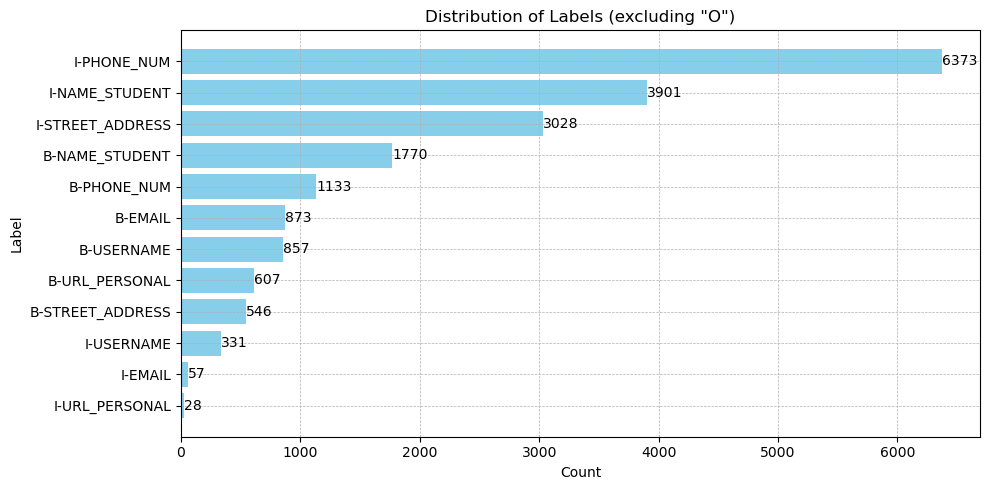

In [ ]:
mistral_df_v2 = pd.read_json("../data/pii_dataset_Mistral_2k_v2.json")
helper.plot_distribution(mistral_df_v2)
del(mistral_df_v2)

No entity ratio:  0.947


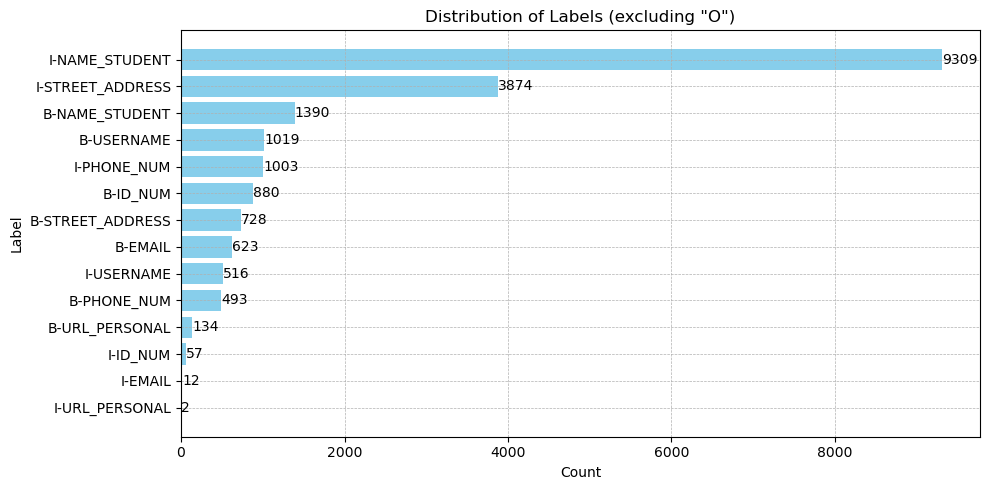

In [ ]:
gemma_df = pd.read_json("../data/pii_dataset_gemma.json")
helper.plot_distribution(gemma_df)
del(gemma_df)

No entity ratio:  0.972


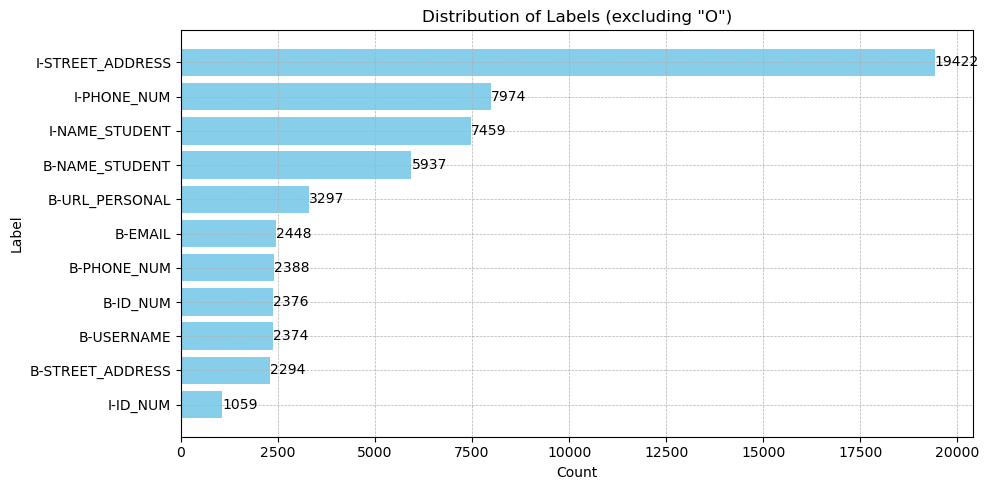

In [ ]:
mistral_df = pd.read_json("../data/mixtral-8x7b-v1.json")
helper.plot_distribution(mistral_df)
del(mistral_df)

In [4]:
df, all_labels, label2id, id2label = helper.load_data()


kaggle train data = 6807
gemma data =  1390
df_mpware data = 2355
all_labels = ['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-EMAIL', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'I-USERNAME', 'O']


No entity ratio:  0.989


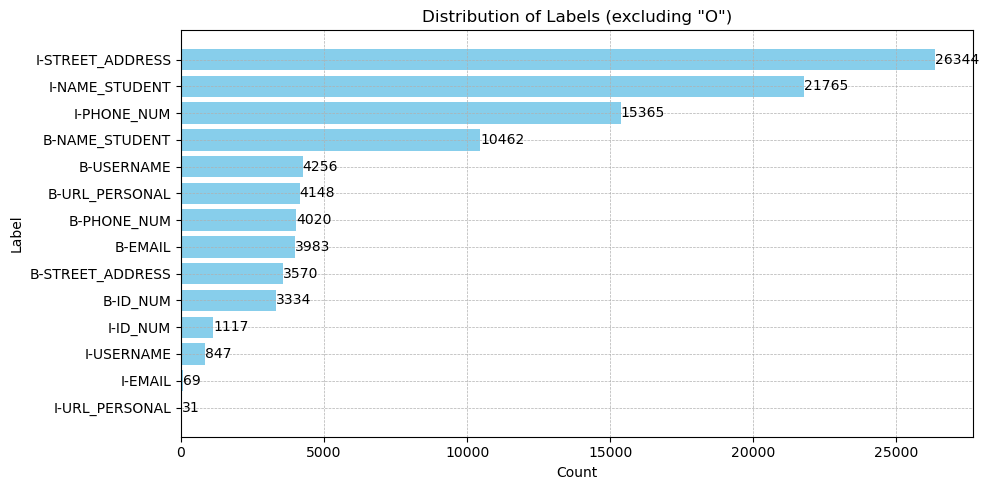

In [ ]:
helper.plot_distribution(df)

In [5]:
import gc
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

clear_memory()

In [ ]:
len(df['tokens'].iloc[0]) == len(df['labels'].iloc[0]) ## checking if the \n\n token also has the corresponding tags in the labels column, it does!


True

In [6]:
def split_df_by_sampling(df, n_samples, SEED=42):
    # Get the sample df
    samples_df = df.sample(n=n_samples, random_state=SEED)
    # The remaining df
    cond = df['document'].isin(samples_df['document'])
    others_df = df.drop(df[cond].index, inplace=False)
    return samples_df, others_df

def downsample_df(df):
    '''Split the df into training and valid dataset'''
    df['is_labels'] = df['labels'].apply(lambda labels: any(label != 'O' for label in labels))
    # One or more labels are not 'O'
    true_labels = df[df['is_labels'] == True]
    # all labels are 'O'
    false_labels = df[df['is_labels'] == False] 
    # Reset index to two df
    true_labels = true_labels.reset_index(drop=True, inplace=False)
    false_labels = false_labels.reset_index(drop=True, inplace=False)
    print(f"Number of true_labels = {len(true_labels)}")
    print(f"Number of false_labels = {len(false_labels)}")
    # Get 300 as valid dataset
    n_samples=len(true_labels) - 150
    # Sample true labels
    true_samples, true_others = split_df_by_sampling(true_labels, n_samples)
    print(f"true_samples = {len(true_samples)} true_others = {len(true_others)}")
    n_samples=len(false_labels) - 150
    # Sample false labels
    false_samples, false_others = split_df_by_sampling(false_labels, n_samples)
    print(f"false_samples = {len(false_samples)} false_others = {len(false_others)}")
    # Training ds = P * true_labels + P * false_labels
    train_df = pd.concat([true_samples, false_samples])   
    # Valid ds = (1-P) * true_labels + (1-P) * false_labels
    valid_df = pd.concat([true_others, false_others])   
    return train_df, valid_df

In [7]:
train_df, valid_df = downsample_df(df.copy())
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
print(f"Number of train_df = {len(train_df)}")
print(f"Number of valid_df = {len(valid_df)}")
clear_memory()

Number of true_labels = 4690
Number of false_labels = 5862
true_samples = 4540 true_others = 150
false_samples = 5712 false_others = 150
Number of train_df = 10252
Number of valid_df = 300


In [8]:
train_dict = {}
train_dict['sentences'] = train_df['tokens'].to_list()
train_dict['tags'] = train_df['labels'].to_list()

validate_dict = {}
validate_dict['sentences'] = valid_df['tokens'].to_list()
validate_dict['tags'] = valid_df['labels'].to_list()

In [9]:
tag_scheme = train_df['labels'].explode().unique().tolist()
tag_scheme.remove('O')

In [10]:
# transformer = 'studio-ousia/luke-base'
#transformer = 'studio-ousia/luke-large'
# transformer = 'bert-base-uncased'
#transformer = 'google/bigbird-roberta-base'
# transformer = 'distilbert-base-uncased'
#transformer = 'distilroberta-base'
#transformer = 'roberta-base'
transformer = 'studio-ousia/luke-base-lite'

In [11]:
# hyperparameters for training
training_hyperparameters = {
'epochs' : 4,
'warmup_steps' : 400,                                                   
'train_batch_size': 8, #very sensitive to batch size; running 8 by default
 'learning_rate': 0.0001
}
tokenizer_params = {
    "padding": True
    }

In [12]:
ner_model = NERDA(dataset_training = train_dict,
              dataset_validation = validate_dict,
              tag_scheme = tag_scheme,
              tag_outside = 'O',
              max_len = 512,
              transformer = transformer,
              dropout = 0.1,
              hyperparameters = training_hyperparameters,
              device='cuda',
              num_workers=8,
              tokenizer_parameters = tokenizer_params)

Device set to: cuda


config.json: 100%|██████████| 836/836 [00:00<?, ?B/s] 
c:\Users\yashb\anaconda3\envs\nlp_new\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yashb\.cache\huggingface\hub\models--studio-ousia--luke-base-lite. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
pytorch_model.bin: 100%|██████████| 589M/589

In [14]:
ner_model.transformer_tokenizer


LukeTokenizer(name_or_path='studio-ousia/luke-base-lite', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['<ent>', '<ent2>', '<ent>', '<ent2>', '<ent>', '<ent2>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
	50265: A

In [15]:
%%time
ner_model.train()

c:\Users\yashb\anaconda3\envs\nlp_new\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 4


100%|██████████| 38/38 [01:36<00:00,  2.53s/it]


Train Loss = 0.06989259254490685 Valid Loss = 0.45563247033083154

 Epoch 2 / 4


100%|██████████| 38/38 [01:38<00:00,  2.60s/it]


Train Loss = 0.009947495407245115 Valid Loss = 0.050546667142474404

 Epoch 3 / 4


100%|██████████| 38/38 [01:39<00:00,  2.61s/it]


Train Loss = 0.0060505474842484875 Valid Loss = 0.015522908159183365

 Epoch 4 / 4


100%|██████████| 38/38 [01:39<00:00,  2.61s/it]

Train Loss = 0.004403246998147934 Valid Loss = 0.006720092811639533
CPU times: total: 19min 54s
Wall time: 7h 40min 44s


'Model trained successfully'

In [17]:
torch.save(ner_model, path_ner_model + '/' + 'luke-base-lite-' + '_ner_model_data_augmented_v1.pt')


In [ ]:
ner_model.evaluate_performance(validate_dict)


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Level</th>
      <th>F1-Score</th>
      <th>Precision</th>
      <th>Recall</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>B-NAME_STUDENT</td>
      <td>0.907063</td>
      <td>0.991870</td>
      <td>0.835616</td>
    </tr>
    <tr>
      <th>1</th>
      <td>I-NAME_STUDENT</td>
      <td>0.971256</td>
      <td>0.996894</td>
      <td>0.946903</td>
    </tr>
    <tr>
      <th>2</th>
      <td>B-ID_NUM</td>
      <td>0.992366</td>
      <td>0.984848</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>3</th>
      <td>B-USERNAME</td>
      <td>0.987500</td>
      <td>0.987500</td>
      <td>0.987500</td>
    </tr>
    <tr>
      <th>4</th>
      <td>B-EMAIL</td>
      <td>0.972222</td>
      <td>0.945946</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>B-URL_PERSONAL</td>
      <td>0.993289</td>
      <td>1.000000</td>
      <td>0.986667</td>
    </tr>
    <tr>
      <th>6</th>
      <td>B-PHONE_NUM</td>
      <td>0.814286</td>
      <td>0.966102</td>
      <td>0.703704</td>
    </tr>
    <tr>
      <th>7</th>
      <td>I-PHONE_NUM</td>
      <td>0.862471</td>
      <td>1.000000</td>
      <td>0.758197</td>
    </tr>
    <tr>
      <th>8</th>
      <td>I-USERNAME</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>9</th>
      <td>B-STREET_ADDRESS</td>
      <td>0.937500</td>
      <td>0.967742</td>
      <td>0.909091</td>
    </tr>
    <tr>
      <th>10</th>
      <td>I-STREET_ADDRESS</td>
      <td>0.986126</td>
      <td>1.000000</td>
      <td>0.972632</td>
    </tr>
    <tr>
      <th>11</th>
      <td>I-EMAIL</td>
      <td>0.666667</td>
      <td>1.000000</td>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>12</th>
      <td>I-ID_NUM</td>
      <td>0.982456</td>
      <td>1.000000</td>
      <td>0.965517</td>
    </tr>
    <tr>
      <th>13</th>
      <td>I-URL_PERSONAL</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>14</th>
      <td>AVG_MICRO</td>
      <td>0.950617</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>15</th>
      <td>AVG_MICRO</td>
      <td>0.862372</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>
</div>

In [19]:
import pandas as pd

# Assuming you have the data in a DataFrame named 'df'
data = {
    "Precision": [0.991870, 0.996894, 0.984848, 0.987500, 0.945946, 1.000000, 0.966102, 1.000000, 1.000000, 0.967742, 1.000000, 1.000000, 1.000000, 0.000000],
    "Recall": [0.835616, 0.946903, 1.000000, 0.987500, 1.000000, 0.986667, 0.703704, 0.758197, 1.000000, 0.909091, 0.972632, 0.500000, 0.965517, 0.000000]
}

df = pd.DataFrame(data)

# Calculate total true positives, false positives, and false negatives
total_true_positives = df['Precision'].sum()
total_false_positives = len(df) - total_true_positives
total_false_negatives = len(df) - df['Recall'].sum()

# Calculate micro-precision and micro-recall
micro_precision = total_true_positives / (total_true_positives + total_false_positives)
micro_recall = total_true_positives / (total_true_positives + total_false_negatives)

print("Micro-Precision:", micro_precision)
print("Micro-Recall:", micro_recall)


Micro-Precision: 0.9172072857142857
Micro-Recall: 0.8406441212236274
